In [10]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi

# ========== Configuration ==========
audio_path = 'gen_audio'
midi_path = 'gen_piano'
num_sample = 50  # Assumes files gen_1.mp3 to gen_(num_sample-1).mp3
sr = 22050
hop_length_sec = 0.01
hop_length = int(hop_length_sec * sr)
fmin = librosa.note_to_hz('A0')
bins_per_octave = 36
n_bins = 267
pitch_min = 21
pitch_max = 108

# ========== Utility Functions ==========
def extract_note_array(midi_path):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    note_array = []
    for instrument in midi_data.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            note_array.append([
                note.start,
                note.end,
                note.pitch,
                note.velocity
            ])
    return np.array(note_array)

def separate_continuous_notes(note_array, epsilon=1e-3):
    separated = []
    for i in range(len(note_array)):
        start, end, pitch, velocity = note_array[i]
        if i < len(note_array) - 1:
            next_start, _, next_pitch, _ = note_array[i + 1]
            if pitch == next_pitch and abs(end - next_start) < 1e-6:
                end = next_start - epsilon
        separated.append([start, end, pitch, velocity])
    return np.array(separated)

def note_array_to_midi(note_array, out_path="temp_fixed.mid"):
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    for start, end, pitch, velocity in note_array:
        piano.notes.append(pretty_midi.Note(
            velocity=int(velocity),
            pitch=int(pitch),
            start=float(start),
            end=float(end)
        ))
    midi.instruments.append(piano)
    midi.write(out_path)
    return out_path

def plot_cqt_with_pianoroll(audio_file, midi_file):
    y, _ = librosa.load(audio_file, sr=sr)

    # Compute CQT
    C = librosa.cqt(
        y, sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave
    )
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    # Fix MIDI notes and convert to new MIDI
    note_array = extract_note_array(midi_file)
    adjusted_note_array = separate_continuous_notes(note_array, epsilon=5e-2)
    temp_midi = f'temp_{os.path.basename(midi_file)}'
    fixed_midi = note_array_to_midi(adjusted_note_array, out_path=temp_midi)

    # Get piano roll
    midi_data = pretty_midi.PrettyMIDI(fixed_midi)
    fs_pianoroll = sr / hop_length
    piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)
    print(C_dB.shape, piano_roll.shape)
    # Align lengths
    n_frames = min(C_dB.shape[1], piano_roll.shape[1])
    return C_dB[:, :n_frames], piano_roll[:, :n_frames]

def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis] 

def create_sliding_windows_midi(midi, window_size=9, stride=1):
    pad = window_size // 2
    midi_padded = np.pad(midi, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
    num_time_bins = midi.shape[1]

    windows = np.array([
        midi_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows, len(windows)




In [ ]:
# # ========== Main Loop for Multiple Samples ==========
# cqt_list = []
# piano_list = []

# for i in range(num_sample):
#     if i:  # starts from 1
#         audio = os.path.join(audio_path, f'gen_{i}.mp3')
#         midi = os.path.join(midi_path, f'gen_{i}.mid')
#         cqt, piano = plot_cqt_with_pianoroll(audio, midi)
#         cqt_list.append(cqt)
#         piano_list.append(piano)

# # ========== Concatenate and Plot ==========
# cqt_concat = np.concatenate(cqt_list, axis=1)
# piano_concat = np.concatenate(piano_list, axis=1)

(267, 978) (128, 776)
(267, 776) (128, 776)


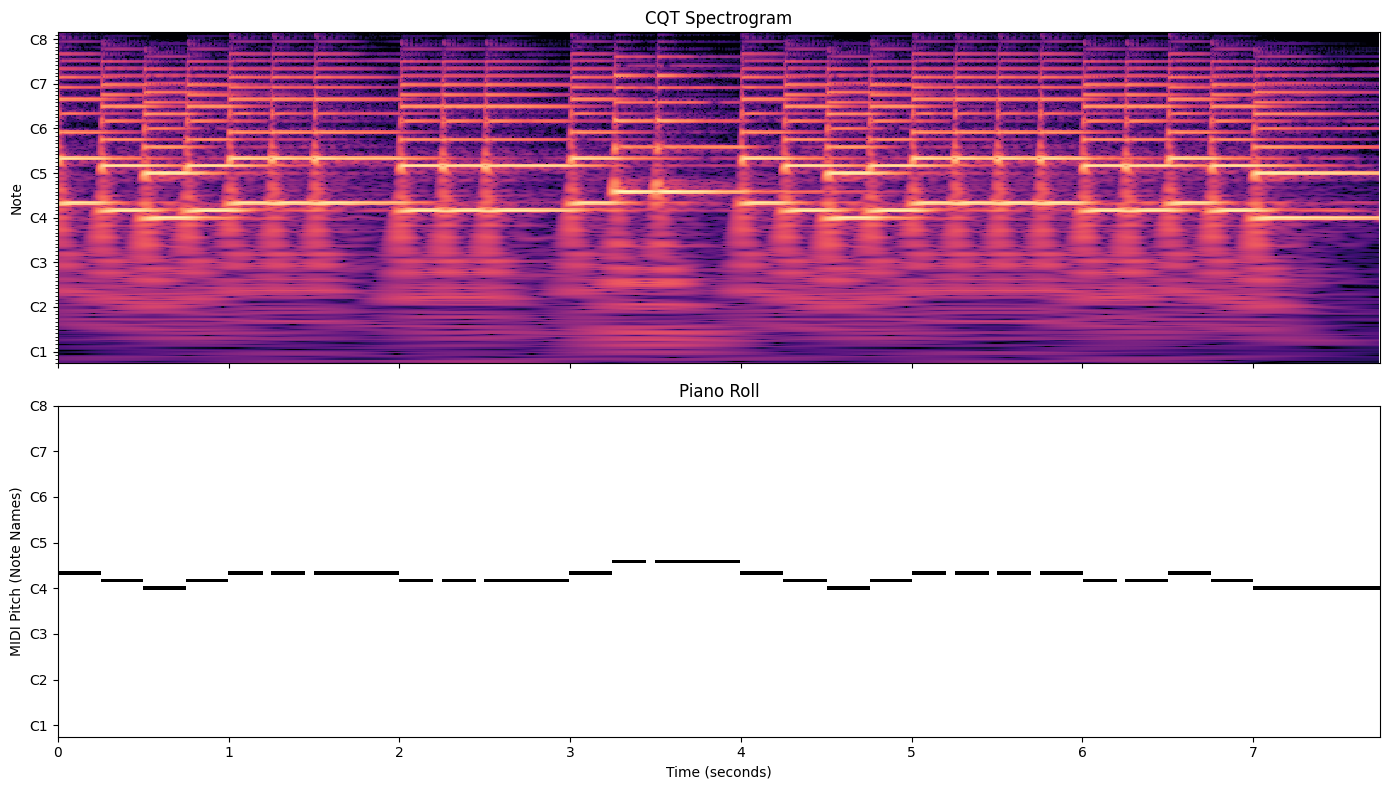

In [32]:
cqt, piano = plot_cqt_with_pianoroll('compare\Mary_input.mp3', r'C:\Users\napat\Documents\GitHub\Open-topic-Music-Transcribe-\library_test\Mary.mid')
print(cqt.shape, piano.shape)
duration_sec = cqt.shape[1] * hop_length / sr

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Plot CQT ---
librosa.display.specshow(
    cqt,
    sr=sr,
    hop_length=hop_length,
    x_axis='s',
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()

# --- Plot Piano Roll ---
axs[1].imshow(
    piano[pitch_min:pitch_max+1],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label C notes only
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()


In [3]:
cqt.shape

(267, 978)

In [4]:
piano.shape

(128, 776)

In [72]:
X_input = create_sliding_windows(cqt_concat, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window Output Shape:", X_input.shape)

Y_output, num_windows_midi = create_sliding_windows_midi(piano_concat, window_size=9, stride=1)
print("Sliding Window MIDI Output Shape:", Y_output.shape)

Sliding Window Output Shape: (49000, 267, 9, 1)
Sliding Window MIDI Output Shape: (49000, 128, 9)


In [73]:
Y_output_flattened = np.mean(Y_output, axis=2) > 80  # Shape: (n, 128)

print("Xtrain : ",X_input.shape)
print("out : ",Y_output.shape)
print("Ytrain : ",Y_output_flattened.shape)

Xtrain :  (49000, 267, 9, 1)
out :  (49000, 128, 9)
Ytrain :  (49000, 128)


In [74]:
from cnn_model import cnn_model
import tensorflow as tf
model = cnn_model()

# model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model.fit(X_input, Y_output_flattened, 
          epochs=20, 
          batch_size=256,
          validation_split=0.2,
        #   callbacks=[tensorboard_callback]
          )
model.save("yyy.h5")

Epoch 1/20


c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.1986 - loss: 0.7442 - val_accuracy: 0.9378 - val_loss: 0.0011
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9203 - loss: 0.0031 - val_accuracy: 0.9378 - val_loss: 4.6612e-04
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9337 - loss: 0.0012 - val_accuracy: 0.9378 - val_loss: 3.3303e-04
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9320 - loss: 8.7483e-04 - val_accuracy: 0.9378 - val_loss: 3.1468e-04
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9351 - loss: 6.5642e-04 - val_accuracy: 0.9378 - val_loss: 3.2985e-04
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9333 - loss: 5.6271e-04 - val_accuracy: 0.9378 - val_loss: 2.8557e-04
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9343 - loss: 4.7198e-04 - val_accuracy: 0.9378 - val_loss: 2.7261e-04
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9

In [49]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_compare_cqt(audio_file1, audio_file2, sr=22050, hop_length=512, fmin=None, bins_per_octave=12, n_bins=84):
    # Load both audio files
    y1, _ = librosa.load(audio_file1, sr=sr)
    y2, _ = librosa.load(audio_file2, sr=sr)

    # Compute CQTs
    C1 = librosa.cqt(y1, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)
    C2 = librosa.cqt(y2, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)

    # Convert amplitude to dB
    C1_dB = librosa.amplitude_to_db(np.abs(C1), ref=np.max)
    C2_dB = librosa.amplitude_to_db(np.abs(C2), ref=np.max)

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

    librosa.display.specshow(C1_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note', ax=ax[0])
    ax[0].set_title('Input Audio')

    librosa.display.specshow(C2_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='cqt_note', ax=ax[1])
    ax[1].set_title('Output Audio')

    plt.tight_layout()
    plt.show()


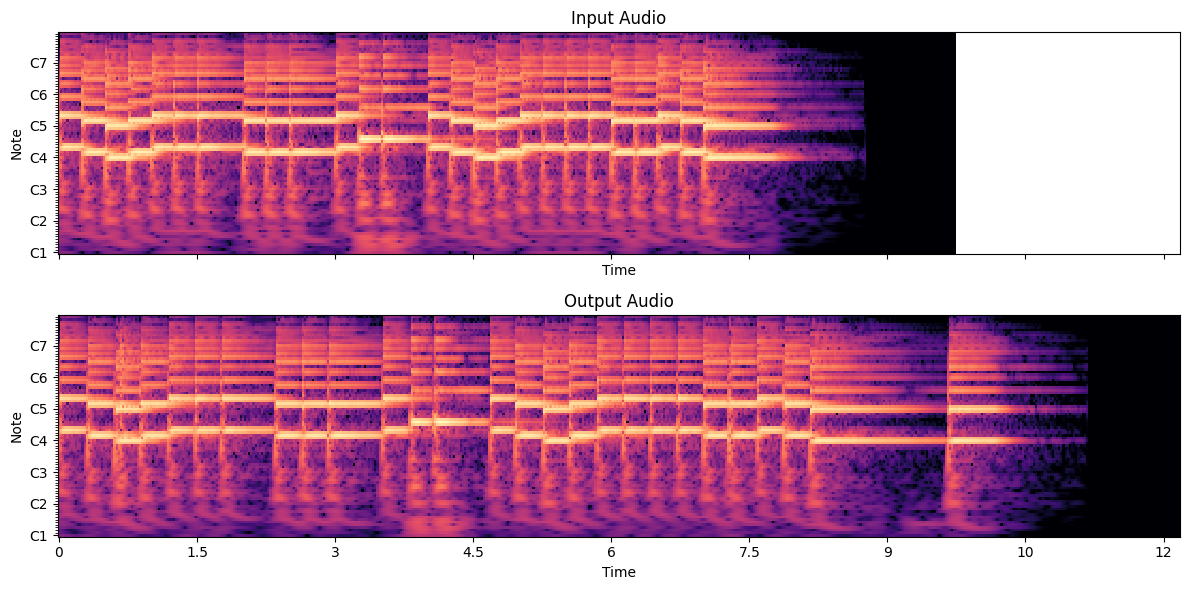

In [50]:
plot_compare_cqt('compare\Mary_input.mp3', 'Fixed-Mary-v4-100e-54b.mp3')


In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_compare_pianoroll_from_audio_midi(audio_file1, midi_file1, audio_file2, midi_file2):
    """
    Compare piano rolls extracted from two audio+MIDI pairs.
    Uses aligned time axis (in seconds) and proper pitch range (0-127).
    """

    # Extract aligned piano rolls using your custom function
    _, piano_roll1 = plot_cqt_with_pianoroll(audio_file1, midi_file1)
    _, piano_roll2 = plot_cqt_with_pianoroll(audio_file2, midi_file2)

    # Align to max time length using zero-padding
    n_frames = max(piano_roll1.shape[1], piano_roll2.shape[1])
    piano_roll1 = np.pad(piano_roll1, ((0, 0), (0, n_frames - piano_roll1.shape[1])), mode='constant')
    piano_roll2 = np.pad(piano_roll2, ((0, 0), (0, n_frames - piano_roll2.shape[1])), mode='constant')

    # Time axis in seconds (sr and hop_length assumed defined globally)
    time_step = hop_length / sr
    extent = [0, n_frames * time_step, 0, 128]  # MIDI note range: 0–127

    # Plot
    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

    ax[0].imshow(piano_roll1, aspect='auto', origin='lower', cmap='gray_r', interpolation='nearest', extent=extent)
    ax[0].set_title('Input MIDI')
    ax[0].set_ylabel('MIDI Note')

    ax[1].imshow(piano_roll2, aspect='auto', origin='lower', cmap='gray_r', interpolation='nearest', extent=extent)
    ax[1].set_title('Output MIDI')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('MIDI Note')

    plt.tight_layout()
    plt.show()


(267, 978) (128, 776)
(267, 1220) (128, 1019)


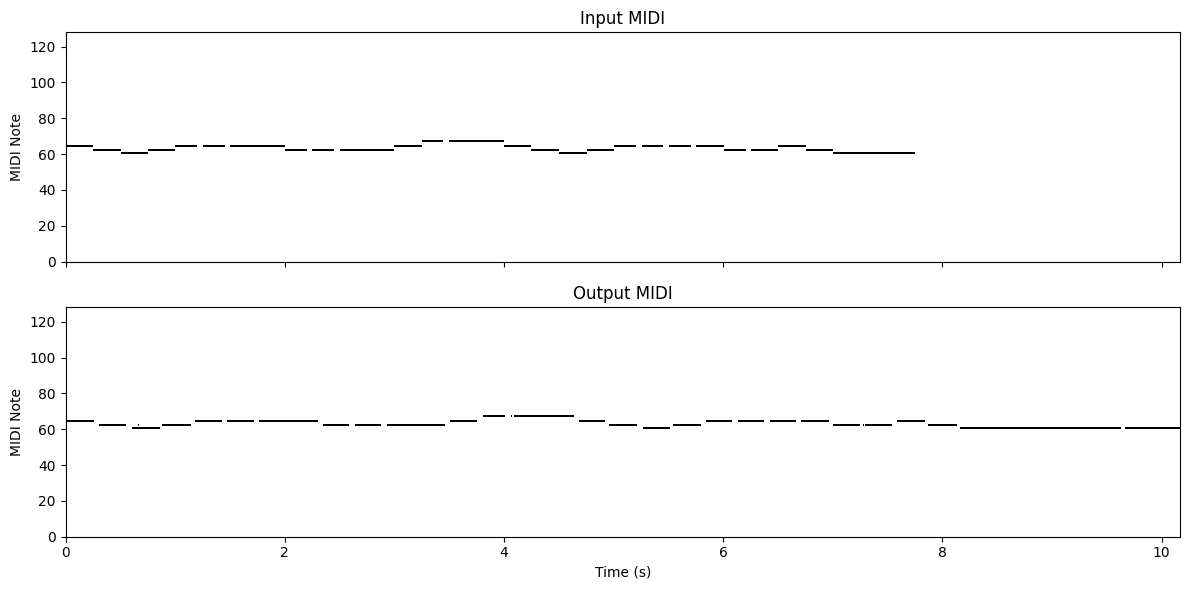

In [48]:
plot_compare_pianoroll_from_audio_midi('compare\Mary_input.mp3', 
                                       r'C:\Users\napat\Documents\GitHub\Open-topic-Music-Transcribe-\library_test\Mary.mid', 
                                       'Fixed-Mary-v4-100e-54b.mp3', 
                                       r'Fixed_Mary_v4_100e_54b.mid')

In [62]:
mi = r'C:\Users\napat\Documents\GitHub\Open-topic-Music-Transcribe-\library_test\Mary.mid'

In [63]:
import pretty_midi

def print_midi_onset_offset(midi_path):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    for instrument in midi_data.instruments:
        print(f"\nInstrument: {instrument.name} (Program {instrument.program})")
        for i, note in enumerate(instrument.notes):
            print(f"Note {i+1}: Pitch={note.pitch}, Onset={note.start:.3f}s, Offset={note.end:.3f}s, Duration={note.end - note.start:.3f}s")


In [64]:
print_midi_onset_offset(mi)



Instrument:  (Program 0)
Note 1: Pitch=64, Onset=0.000s, Offset=0.250s, Duration=0.250s
Note 2: Pitch=62, Onset=0.250s, Offset=0.500s, Duration=0.250s
Note 3: Pitch=60, Onset=0.500s, Offset=0.750s, Duration=0.250s
Note 4: Pitch=62, Onset=0.750s, Offset=1.000s, Duration=0.250s
Note 5: Pitch=64, Onset=1.000s, Offset=1.250s, Duration=0.250s
Note 6: Pitch=64, Onset=1.250s, Offset=1.500s, Duration=0.250s
Note 7: Pitch=64, Onset=1.500s, Offset=2.000s, Duration=0.500s
Note 8: Pitch=62, Onset=2.000s, Offset=2.250s, Duration=0.250s
Note 9: Pitch=62, Onset=2.250s, Offset=2.500s, Duration=0.250s
Note 10: Pitch=62, Onset=2.500s, Offset=3.000s, Duration=0.500s
Note 11: Pitch=64, Onset=3.000s, Offset=3.250s, Duration=0.250s
Note 12: Pitch=67, Onset=3.250s, Offset=3.500s, Duration=0.250s
Note 13: Pitch=67, Onset=3.500s, Offset=4.000s, Duration=0.500s
Note 14: Pitch=64, Onset=4.000s, Offset=4.250s, Duration=0.250s
Note 15: Pitch=62, Onset=4.250s, Offset=4.500s, Duration=0.250s
Note 16: Pitch=60, Onse